# Load Libraries

In [8]:
# packages
import os
import h5py
import time
import random
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
from time import gmtime, strftime
import numpy as np
import random
import keras.backend as K
from tensorflow import keras
from keras import layers
from keras import models
from keras import regularizers
from keras.models import model_from_json
from sklearn.utils import shuffle


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.decomposition import PCA
# import tensorflow_addons as tfa

# EVALUATION modules
from scipy.stats import spearmanr

params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)


# Helper Functions

## Metrics

In [ ]:
# mape error
def mape(real,predicted):
    return np.mean(np.abs((real - predicted) / real)) * 100

def mae(real,predicted):
    return np.mean(np.abs(real - predicted))

def rmse(real,predicted):
    return np.sqrt(np.mean((real - predicted)**2))

## Preprocessing

In [ ]:
def normalize_data(x, lb, ub, max_v=1.0, min_v=-1.0):

    # Set-up
    if (lb == []) & (ub == []):
        # OPTION 1:
        ub = x.max(0)
        lb = x.min(0)
    
        # OPTION 2:
        #ub = np.percentile(x, 99.9, axis=0, keepdims=True)
        #lb = np.percentile(x, 0.1, axis=0, keepdims=True)
    
    ub.shape = (1,-1)
    lb.shape = (1,-1)           
    max_min = max_v - min_v
    delta = ub-lb

    # Compute
    x_n = max_min * (x - lb) / delta + min_v
    if 0 in delta:
        idx = np.ravel(delta == 0)
        x_n[:,idx] = x[:,idx] - lb[:, idx]

    return x_n, lb, ub 


def split_dataset(dataset, split=4): 
    '''
    Split 'dataset' in tree pieces: w, x_s, theta
    '''
    w = dataset[:,:split]
    x_s = dataset[:,split:20]
    theta = dataset[:,-10:]
    tmp = theta[:,6]
    tmp.shape = (-1,1)
    
    return w, x_s, tmp

def extract_units_ds(id_en, ds, units):
    '''
    Creates a subset with only id_en units for ds
    '''
    
    # Set-up
    ds_sub = []
    units_unique = np.unique(units)

    # Process
    for i in units_unique:
        if i in id_en:
            idx = np.ravel(units==i)
            ds_sub.append(ds[idx,:])           
    
    return np.concatenate(ds_sub, axis=0)

def create_lag_data(w, x_s, theta, y, Units, Cycles, stride=1):
    # Set-up
    W, X, T, Y, U, C, _W, _X = [], [], [], [], [], [], [], []
    
    # Loop over units and then within the units
    units = np.unique(Units)
    for k in units:
        unit = np.ravel(Units == k)
        w_unit = w[unit,:]
        x_s_unit = x_s[unit,:]
        T_unit = theta[unit,:]
        Y_unit = y[unit,:]
        U_unit = Units[unit,:]
        C_unit = Cycles[unit,:]
        dim = w_unit.shape[0]
        for i in range(dim-1): 
            X.append(x_s_unit[i + stride, :])          # X  or X_
            W.append(w_unit[i + stride, :])            # W  or W_
            T.append(T_unit[i + stride, :])            # T  or T_
            Y.append(Y_unit[i + stride, :])            # T  or T_
            U.append(U_unit[i + stride, :])            # U  or U_
            C.append(C_unit[i + stride, :])            # C  or C_
            _X.append(x_s_unit[i, :])                  # _X or X
            _W.append(w_unit[i, :])                  # _X or X
            
    return np.array(W), np.array(X), np.array(T), np.array(Y), np.array(U), np.array(C), np.array(_X), np.array(_W)


def sample_data(xs,w,y,t,units,cycles,hi,freq,mean = False):
    X_out,W_out,Y_out,T_out,U_out,C_out,HI_out= [], [], [], [], [], [] , []
    uniq_units=np.unique(units)
    for k in uniq_units:
        unit = np.ravel(units == k)
        u_unit=units[unit,:]
        w_unit = w[unit,:]
        x_s_unit = xs[unit,:]
        y_unit= y[unit,:]
        t_unit= t[unit,:]
        c_unit= cycles[unit,:]
        h_unit = hi[unit]
        
        if mean:
            for i in range(0,x_s_unit.shape[0],freq):
                X_out.append(np.mean(x_s_unit[i:i+freq,:],axis=0))
                W_out.append(np.mean(w_unit[i:i+freq,:],axis=0))
                Y_out.append(np.mean(y_unit[i:i+freq,:],axis=0))
                T_out.append(np.mean(t_unit[i:i+freq,:],axis=0))
                HI_out.append(np.mean(h_unit[i:i+freq,:],axis=0))
            
            C_out.extend(c_unit[::freq])
            U_out.extend(u_unit[::freq])
        else:
        
            X_out.extend(x_s_unit[::freq,])
            W_out.extend(w_unit[::freq,])
            Y_out.extend(y_unit[::freq])
            U_out.extend(u_unit[::freq])
            T_out.extend(t_unit[::freq])
            C_out.extend(c_unit[::freq])
            HI_out.extend(h_unit[::freq])
            
    return  np.array(X_out).astype(np.float16),\
            np.array(W_out).astype(np.float16),\
            np.array(Y_out).astype(np.float16),\
            np.array(T_out).astype(np.float16),\
            np.array(U_out).astype(np.float16),\
            np.array(C_out).astype(np.float16),\
            np.array(HI_out).astype(np.float16)


# np.array(X_out), np.array(W_out), np.array(Y_out), np.array(T_out), np.array(U_out), np.array(C_out), np.array(HI_out)

def split_sequences(input_data, sequence_length, stride = 1, option = None):
    """
     
    """
    X = list()
    
    for i in range(0,len(input_data),stride):
        # find the end of this pattern
        end_ix = i + sequence_length
        
        # check if we are beyond the dataset
        if end_ix > len(input_data):
            break
        
        # gather input and output parts of the pattern
        if option=='last':
            seq_x = input_data[end_ix-1, :]
        elif option=='next':
            seq_x = input_data[end_ix, :]
        else:
            seq_x = input_data[i:end_ix, :]
        X.append(seq_x)
    
    return np.array(X)



# def sequence_generator(input_data, units, sequence_length=10, option=None):
#     """
#      # Generates dataset with windows of sequence_length      
#     """  
#     X = list()
#     unit_num=[]
#     for i, elem_u in enumerate(list(np.unique(units))):
#         mask = np.ravel(units==elem_u)
#         seq_x_u = split_sequences(input_data[mask],sequence_length, option)
#         X.append(seq_x_u)
#         unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
    
#     return np.vstack(X),unit_num


## Plots

In [ ]:
def plot_sensor_signal(x_real,x_pred,var_names,num=1000,figsize=10):
    input_dim = len(var_names)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    fig  = plt.figure(figsize=(figsize, max(figsize, rows*2)))   
    for i in range(input_dim):
        ax = fig.add_subplot(gs[i])
        # ax.plot(np.arange(0,num),x_real[-num:,i],label="True",marker='.',markeredgewidth=0.25, markersize=8)
        # ax.plot(np.arange(0,num),x_pred[-num:,i],label="Pred",marker='.',markeredgewidth=0.25, markersize=8)
        ax.scatter(np.arange(0,num),x_real[-num:,i],label="True",marker='.')
        ax.scatter(np.arange(0,num),x_pred[-num:,i],label="Pred",marker='.')
        plt.title(var_names[i])
        ax.legend()
    plt.tight_layout()
    plt.show()

##  Sequence Generator

In [ ]:
def sequence_generator(input_data, units, cycles, sequence_length=10,stride = 1, option=None):
    """
     # Generates dataset with windows of sequence_length      
    """  
    X = list()
    unit_num=[]
    c_num =[]
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        c_mask = cycles[mask]
        x_unit = input_data[mask]
        for j in np.unique(c_mask):
            mask = np.ravel(c_mask==j)
            seq_x_u = split_sequences(x_unit[mask],sequence_length, stride, option)
            X.append(seq_x_u)
            unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
            c_num.extend(np.ones(len(seq_x_u),dtype = int)*j)
    
    return np.vstack(X),np.array(unit_num).reshape(-1,1),np.array(c_num).reshape(-1,1)


def sequence_generator_per_unit(input_data, units, cycles, sequence_length=10, stride =1,option=None):
    """
     # Generates dataset with windows of sequence_length      
    """  
    X = list()
    unit_num=[]
    c_num =[]
    for i, elem_u in enumerate(list(np.unique(units))):
        mask = np.ravel(units==elem_u)
        x_unit = input_data[mask]
        seq_x_u = split_sequences(x_unit,sequence_length, stride, option)
        X.append(seq_x_u)
        unit_num.extend(np.ones(len(seq_x_u),dtype = int)*elem_u)
        c_num.append(split_sequences(cycles[mask],sequence_length, stride, option))
    
    return np.vstack(X),np.array(unit_num).reshape(-1,1),np.vstack(c_num)

## Sampling

In [9]:
def sample_healthy(data,units,cycles,cycle_len,sample_len=1):
    X,U,C=[],[],[]
    uniq_units=np.unique(units)
    for i in uniq_units:
        idx=np.ravel(units==i)
        cy=cycles[idx]
        x=data[idx,:]
        u=units[idx]
        cyidx=np.ravel(cy<=cycle_len)
        x=x[cyidx,:]
        u=u[cyidx]
        cyy = cy[cyidx]
        X.extend(x[::sample_len,:])
        U.extend(u[::sample_len])
        C.extend(cyy[::sample_len])
        
    return np.array(X), np.array(U), np.array(C)

def sample_healthy_mixed(data,units,cycles,starts,cycle_len,full=False):
    X,U,C=[],[],[]
    uniq_units=np.unique(units)
    for i in range(len(uniq_units)):
        idx=np.ravel(units==uniq_units[i])
        cy=cycles[idx]
        x=data[idx,:]
        u=units[idx]
        if full:
            cyidx=np.ravel((cy>=starts[i]))
        else:
            cyidx=np.ravel((cy>=starts[i])&(cy<=cycle_len+starts[i]))
        x=x[cyidx,:]
        u=u[cyidx]
        cyy = cy[cyidx]
        X.extend(x)
        U.extend(u)
        C.extend(cyy)
        
    return np.array(X), np.array(U), np.array(C)

## Smooth

In [1]:
from scipy import stats
def smooth_z_cycle(HI,T,units):
    results = []
    stds = []
    cycle_num =[]
    unit_num =[]
    for j in np.unique(units):
        idx = np.ravel(units==j)
        HI_unit = HI[idx]
        T_unit = T[idx].astype('float64')
        for jj in np.unique(T_unit):
            idxT = np.ravel(T_unit==jj)
            HI_mu_cycle = np.mean(HI_unit[idxT])
            std_cycle = np.std(HI_unit[idxT])
            results.append(HI_mu_cycle)
            stds.append(std_cycle)
            cycle_num.append(jj)
            unit_num.append(j)
    return np.array(results), np.array(stds),np.array(cycle_num),np.array(unit_num)

# Models

## RUL MODEL

In [ ]:
#RUL MODEL

def predictor(t=64,
      feature_X_in=14,
      feature_W_in=4,
      feature_H_in=1,
      feature_out_size=1,
      activation='relu',
      filter = [10,10,1],
      filter_size = 10,
      useH=True):
    
    '''
    useH: if True, use H as input
        [X,W,H] -> Y 
    else:
        [X,W] -> Y
    '''

    x_in=layers.Input(shape=(t,feature_X_in),name="X_in")
    w_in = layers.Input(shape=(t,feature_W_in),name="W_in")
    
    
    if useH:
      h_in = layers.Input(shape=(t,feature_H_in),name="H_in")
      # h_in = layers.Input(shape=(1,1),name="H_in")
      x = tf.concat([x_in,w_in, h_in],-1)
    else: 
      x = tf.concat([x_in,w_in],-1)
      
    for i in filter:
      x = layers.Conv1D(i,filter_size,1,padding='same',activation = activation)(x)
      # x = layers.BatchNormalization()(x)
      
    x = layers.Flatten()(x)
    y = layers.Dense(50,activation = activation)(x)
    y = layers.Dense(feature_out_size,activation = 'linear')(y)

    if useH:
      model = models.Model([x_in,w_in,h_in], y)
    else:
      model = models.Model([x_in,w_in], y)

    return model

## MODEL FCN

In [ ]:
#AE MODEL FCN
def AE(original_dimX,original_dimW,latent_dims,z_size = 1):
    
    inpX = layers.Input(shape=(original_dimX,))
    inpW = layers.Input(shape=(original_dimW,))
    x = tf.concat([inpX,inpW],axis = -1)
        

    for i in latent_dims:
        x=tf.keras.layers.Dense(i,activation='relu')(x)
        
    z = tf.keras.layers.Dense(z_size,name="Z")(x)
     
    x = tf.keras.layers.Concatenate()([z, inpW])
            
    for i in reversed(list(latent_dims)):
        x=tf.keras.layers.Dense(i,activation='relu')(x) 
    x=tf.keras.layers.Dense(original_dimX,name='X')(x)   
       
    model = models.Model([inpX,inpW],x)
    return model

# Model construction

## Load Data

In [10]:
SOURCE = 'N-CMAPSS_DS03-012'

with h5py.File(SOURCE + '.h5', 'r') as hdf:
        # Development set
        W_train = np.array(hdf.get('W_dev'))             # W
        X_s_train = np.array(hdf.get('X_s_dev'))         # X_s
        # X_v_train = np.array(hdf.get('X_v_dev'))         # X_v
        T_train = np.array(hdf.get('T_dev'))             # T
        Y_train = np.array(hdf.get('Y_dev'))             # RUL  
        A_train = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        # X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                             
print('')
# print("Operation time (min): " , (time.clock()-t)/60)
print('')
units_train=A_train[:,0].reshape(-1,1)
cycles_train=A_train[:,1].reshape(-1,1)
fc_train = A_train[:,2].reshape(-1,1)
hi_train = A_train[:,-1]

units_test=A_test[:,0].reshape(-1,1)
cycles_test=A_test[:,1].reshape(-1,1)
fc_test = A_test[:,2].reshape(-1,1)
hi_test = A_test[:,-1]
print("XS_train",X_s_train.shape)
print(units_train.shape)



XS_train (5571277, 14)
(5571277, 1)


In [11]:
# SCALE

# scaler_X = MinMaxScaler(feature_range=(-1,1))
scaler_X = MinMaxScaler()
X_s_train = scaler_X.fit_transform(X_s_train)
X_s_test = scaler_X.transform(X_s_test)

# scaler_W = MinMaxScaler(feature_range=(-1,1))
scaler_W = MinMaxScaler()
W_train = scaler_W.fit_transform(W_train)
W_test = scaler_W.transform(W_test)


In [12]:
#optional subsample data
# AND float16 precision (25% memory reduction)
sample_freq=10

# # SAMPLE
X_s_Train,W_Train,Y_Train,T_Train,units_Train,cycles_Train,hi_Train=sample_data(
    X_s_train,W_train,Y_train,T_train,units_train,cycles_train,hi_train,sample_freq)

X_s_Test,W_Test,Y_Test,T_Test,units_Test,cycles_Test,hi_Test=sample_data(
    X_s_test,W_test,Y_test,T_test,units_test,cycles_test,hi_test,sample_freq)

#MEAN

# X_s_Train,W_Train,Y_Train,T_Train,units_Train,cycles_Train,fc_Train=sample_data(
#     X_s_train,W_train,Y_train,T_train,units_train,cycles_train,fc_train,sample_freq,mean=True)

# X_s_Test,W_Test,Y_Test,T_Test,units_Test,cycles_Test,fc_Test=sample_data(
#     X_s_test,W_test,Y_test,T_test,units_test,cycles_test,fc_test,sample_freq,mean=True)

In [13]:
WINDOW_LEN = 50
stride = 1

X_windows, U_windows, C_windows=sequence_generator(X_s_Train,units_Train,cycles_Train,sequence_length=WINDOW_LEN,stride = stride)
W_windows,_,_=sequence_generator(W_Train,units_Train,cycles_Train,sequence_length=WINDOW_LEN,stride = stride)
Y_windows,_,_=sequence_generator(Y_Train,units_Train,cycles_Train,sequence_length=WINDOW_LEN,option='last',stride = stride)

X_windows_test, U_windows_test,C_windows_test=sequence_generator(X_s_Test,units_Test,cycles_Test,sequence_length=WINDOW_LEN,stride = stride)
W_windows_test,_,_=sequence_generator(W_Test,units_Test,cycles_Test,sequence_length=WINDOW_LEN,stride = stride)
Y_windows_test,_,_=sequence_generator(Y_Test,units_Test,cycles_Test,sequence_length=WINDOW_LEN,option='last',stride = stride)


## RUL MODEL

In [15]:
seed = 229
np.random.seed(seed)
shuffle_idx = np.random.permutation(X_windows.shape[0])
training_idx, val_idx = shuffle_idx[X_windows.shape[0]//10:],shuffle_idx[:X_windows.shape[0]//10]

In [16]:
LAYERS = [64,32]
LR = 0.0001
BATCH_SIZE = 128
EPOCHS = 10

x_temp = X_windows
w_temp = W_windows
y_temp = Y_windows

t = X_windows.shape[1]
rul_model = predictor(t=t,useH=False,filter = LAYERS)
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR,amsgrad=True)
LOSS = tf.keras.losses.MeanAbsoluteError()
# LOSS = tf.keras.losses.MeanSquaredError()
rul_model.compile(optimizer=OPTIMIZER, 
        loss= LOSS)
        
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)  


train_ds = tf.data.Dataset.from_tensor_slices(((x_temp[training_idx],w_temp[training_idx]),y_temp[training_idx]))
train_ds = train_ds.shuffle(buffer_size=x_temp.shape[0]//10).batch(BATCH_SIZE)     
val_ds = tf.data.Dataset.from_tensor_slices(((x_temp[val_idx],w_temp[val_idx]),y_temp[val_idx]))    
val_ds = val_ds.shuffle(buffer_size=x_temp.shape[0]//10).batch(BATCH_SIZE) 
history = rul_model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds,verbose=1,callbacks = [callback])

Epoch 1/10
3689/3689 [==============================] - 122s 32ms/step - loss: 15.2691 - val_loss: 7.7508
Epoch 2/10
3689/3689 [==============================] - 117s 31ms/step - loss: 7.0988 - val_loss: 6.3173
Epoch 3/10
3689/3689 [==============================] - 117s 31ms/step - loss: 6.4518 - val_loss: 6.9051
Epoch 4/10
3689/3689 [==============================] - 121s 32ms/step - loss: 6.2932 - val_loss: 5.6204
Epoch 5/10
3689/3689 [==============================] - 120s 32ms/step - loss: 6.2268 - val_loss: 6.2437
Epoch 6/10
3689/3689 [==============================] - 120s 32ms/step - loss: 6.2133 - val_loss: 6.0445
Epoch 7/10
3689/3689 [==============================] - 124s 33ms/step - loss: 6.1360 - val_loss: 6.3163
Epoch 8/10
3689/3689 [==============================] - 125s 34ms/step - loss: 6.0847 - val_loss: 6.0441
Epoch 9/10
3689/3689 [==============================] - 120s 32ms/step - loss: 6.0606 - val_loss: 6.4782


## MODEL FCN

In [18]:
m = AE(14,4,[128,64,16],z_size=1)
LOSS = tf.keras.losses.MeanAbsoluteError()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005)
m.compile(optimizer=OPTIMIZER, 
          loss= LOSS)

Epoch 1/10
2247/2247 [==============================] - 11s 4ms/step - loss: 0.0126
Epoch 2/10
2247/2247 [==============================] - 9s 4ms/step - loss: 0.0030
Epoch 3/10
2247/2247 [==============================] - 10s 4ms/step - loss: 0.0027
Epoch 4/10
2247/2247 [==============================] - 9s 4ms/step - loss: 0.0026
Epoch 5/10
2247/2247 [==============================] - 10s 4ms/step - loss: 0.0026
Epoch 6/10
2247/2247 [==============================] - 9s 4ms/step - loss: 0.0024
Epoch 7/10
2247/2247 [==============================] - 9s 4ms/step - loss: 0.0024
Epoch 8/10
2247/2247 [==============================] - 10s 4ms/step - loss: 0.0023
Epoch 9/10
2247/2247 [==============================] - 9s 4ms/step - loss: 0.0023
Epoch 10/10
2247/2247 [==============================] - 9s 4ms/step - loss: 0.0024


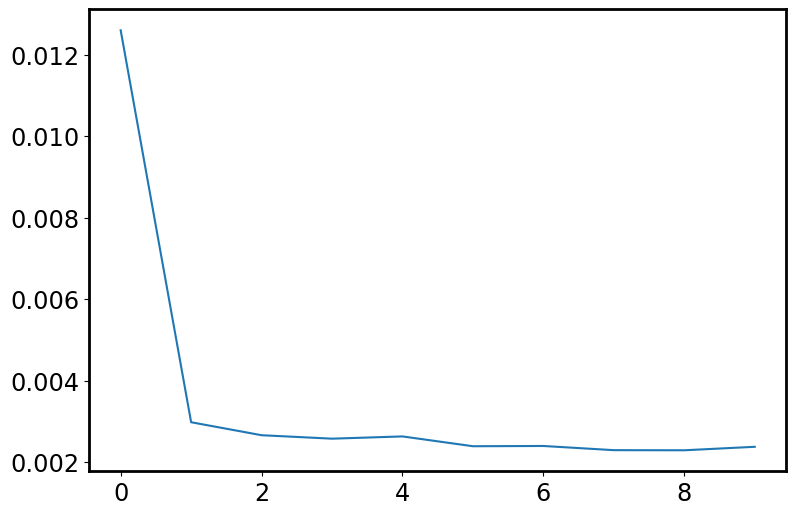

In [19]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_s_Train,W_Train),X_s_Train))
train_ds = train_ds.shuffle(buffer_size=10000).batch(248)
history = m.fit(train_ds,epochs = 10,verbose=1)
plt.plot(history.history['loss'])